In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from pandas.plotting import scatter_matrix

from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer
from sklearn import linear_model
from sklearn.metrics import r2_score

In [2]:
dataset = pd.read_csv('../databases/Tcritical.csv', comment='#')
# dataset.shape[0]
dataset.head()

,file,macro,C,Mn,Si,Cr,Ni,A1,A1prime,A3,eutectoid
0,../results/00000.DAT,../macros_thermocalc/macro_1.tcm,0.0,0.000001,0.000001,0.000001,0.000001,NaN,NaN,1184.80,hipo
1,../results/00001.DAT,../macros_thermocalc/macro_1.tcm,0.0,0.000001,0.000001,0.000001,0.007501,NaN,NaN,1153.41,hipo
2,../results/00002.DAT,../macros_thermocalc/macro_1.tcm,0.0,0.000001,0.000001,0.000001,0.015000,NaN,NaN,1126.40,hipo
3,../results/00003.DAT,../macros_thermocalc/macro_1.tcm,0.0,0.000001,0.000001,0.000001,0.022500,NaN,NaN,1102.75,hipo
4,../results/00004.DAT,../macros_thermocalc/macro_1.tcm,0.0,0.000001,0.000001,0.000001,0.030000,NaN,NaN,1081.80,hipo


In [3]:
def fit_polynomial(tcrit, eutectoid, degree, reg=linear_model.LinearRegression()):
    
    if not eutectoid:
        sel = ~np.isnan(dataset[tcrit].values)
        
    else:
        sel = ~np.isnan(dataset[tcrit].values) & (dataset.eutectoid == eutectoid)
    
    filtered_dataset = dataset[sel]
    
    ind_var = filtered_dataset[['C', 'Mn', 'Si', 'Cr', 'Ni']]*100
    
    dep_var = filtered_dataset[tcrit].values
    
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    ind_var_ = poly.fit_transform(ind_var)

    reg.fit(ind_var_, dep_var)
    
    fitting_summary = {
        'filtered_dataset': filtered_dataset,
        'poly': poly,
        'reg': reg,
        'dep_var': dep_var,
        'ind_var_': ind_var_
    }
    
    return fitting_summary

In [4]:
def rename_ind_var_names(ind_var_names):
    ind_var_names = list(map(lambda x: str.replace(x, 'x0', 'C'), ind_var_names))
    ind_var_names = list(map(lambda x: str.replace(x, 'x1', 'Mn'), ind_var_names))
    ind_var_names = list(map(lambda x: str.replace(x, 'x2', 'Si'), ind_var_names))
    ind_var_names = list(map(lambda x: str.replace(x, 'x3', 'Cr'), ind_var_names))
    ind_var_names = list(map(lambda x: str.replace(x, 'x4', 'Ni'), ind_var_names))
    return ind_var_names

In [5]:
def fit_any_function(tcrit, eutectoid, f, reg=linear_model.LinearRegression()):
    
    if not eutectoid:
        sel = ~np.isnan(dataset[tcrit].values)
        
    else:
        sel = ~np.isnan(dataset[tcrit].values) & (dataset.eutectoid == eutectoid)
    
    filtered_dataset = dataset[sel]
    
    ind_var = filtered_dataset[['C', 'Mn', 'Si', 'Cr', 'Ni']]*100
    
    dep_var = filtered_dataset[tcrit].values
    
    poly = FunctionTransformer(f)
    ind_var_ = poly.fit_transform(ind_var)

    reg.fit(ind_var_, dep_var)
    
    fitting_summary = {
        'filtered_dataset': filtered_dataset,
        'poly': poly,
        'reg': reg,
        'dep_var': dep_var,
        'ind_var_': ind_var_
    }
    
    return fitting_summary

In [6]:
def predict_poly(smry, predict, transform=True):
    if transform:
        predict_ = smry['poly'].fit_transform(predict)
    else:
        predict_ = predict
    return smry['reg'].predict(predict_)

In [7]:
def get_coeficients(poly, clf, predict):
    print(poly.get_feature_names())
    
    print(reg.coef_)
    print(reg.intercept_)
    
    predict_ = poly.fit_transform(predict)
    print(reg.predict(predict_))

In [8]:
def plot_fit(smry):
    dep_var, reg, ind_var_ = smry['dep_var'], smry['reg'], smry['ind_var_']
    plt.plot(dep_var, reg.predict(ind_var_), 'kx')
    Tmin, Tmax = np.min(dep_var), np.max(dep_var)
    plt.plot([Tmin, Tmax], [Tmin, Tmax], 'r-')    

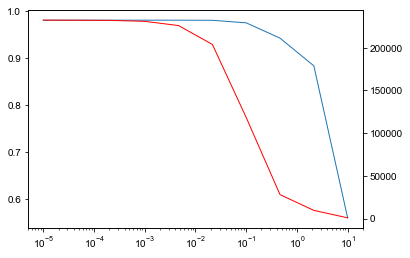

In [9]:
alphalist = 10**np.linspace(-5, 1, 10)
coef2 = []
r2 = []
for alpha in alphalist:
    smry = fit_polynomial('A3', 'hipo', 2, reg=linear_model.Lasso(alpha=alpha))

    coef2 += [np.sum(np.array(smry['reg'].coef_)**2)]
    r2 += [r2_score(smry['dep_var'], predict_poly(smry, smry['ind_var_'], False))]
    
# plt.legend(loc='right')

fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(alphalist, r2)
ax2.plot(alphalist, coef2, color='r')
# ax2.set_yscale('log')
ax.set_xscale('log')

# fig, ax3 = plt.subplots()
# plot_fit(smry)

[-31.32976337 -40.79177727  15.91372757  15.61134367  -9.68710173
   8.32035     28.73138959  -2.26957705  -4.44541568   5.26295793
  -0.30713433  -1.96380707  -2.73187009 -16.39490723   3.15002673
   0.25250417  -2.33404557  -0.64510934  -2.42601778  -9.1736445 ]


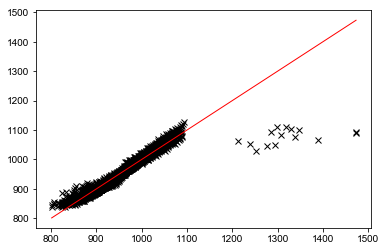

In [10]:
# def f(X):
#     C, Mn, Si, Cr, Ni = X.T
#     X_ = np.vstack([C, C**2, C**2*Mn, C**2*Si, C**2*Cr, C**2*Ni, C*Mn, C*Si, C*Cr, C*Ni, Mn, Mn*Si, Mn*Cr, Mn*Ni, Mn**2, Si, Si*Cr, Si*Ni, Si**2, Cr, Cr*Ni, Cr**2, Ni, Ni**2]).T
#     return X_

# smry = fit_polynomial('A3', 'hipo', 2, reg=linear_model.Lasso())
# print(smry['reg'].coef_)
# plot_fit(smry)

# smry = fit_polynomial('A3', 'hipo', 2, reg=linear_model.Ridge(alpha=.01, normalize=True))
smry = fit_polynomial('A1', None, 2, reg=linear_model.LinearRegression())
# smry = fit_any_function('A3', 'hipo', f, reg=linear_model.LinearRegression())
print(smry['reg'].coef_)
plot_fit(smry)

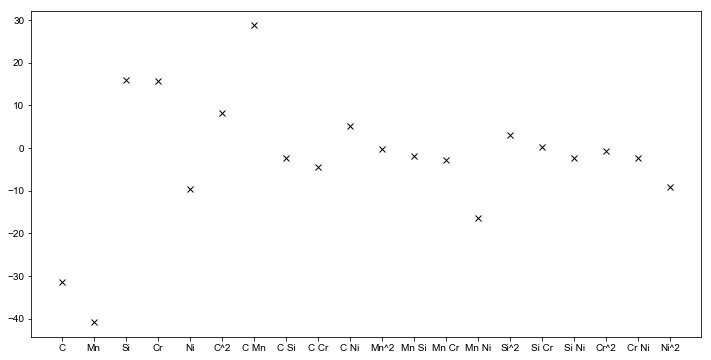

In [11]:
fig, ax = plt.subplots(figsize=(12,6))
ind_var_names = smry['poly'].get_feature_names()
ind_var_names = rename_ind_var_names(ind_var_names)
ax.plot(ind_var_names, smry['reg'].coef_, 'kx')

Int64Index([  76,   85,   90,   95,  102,  107,  111,  112,  116,  121,  226,
             230,  235,  240,  245,  798,  875,  900,  905,  947, 1001, 1041,
            1046, 1201, 1206, 1211, 1231, 1236, 1241, 1246, 1398, 1500, 1512,
            1525, 1547, 1625, 1646, 1737, 1742, 1816, 1841, 1846, 1871, 2119,
            2147, 2208, 2250, 2312, 2342, 2347, 2372, 2375, 2391, 2421, 2477,
            3112, 3117, 3522, 3657, 3722, 3747, 3889, 4018, 4519, 4897, 5149,
            5473, 6038, 6073, 6228, 6252, 6253, 6633, 6850, 6858],
           dtype='int64')


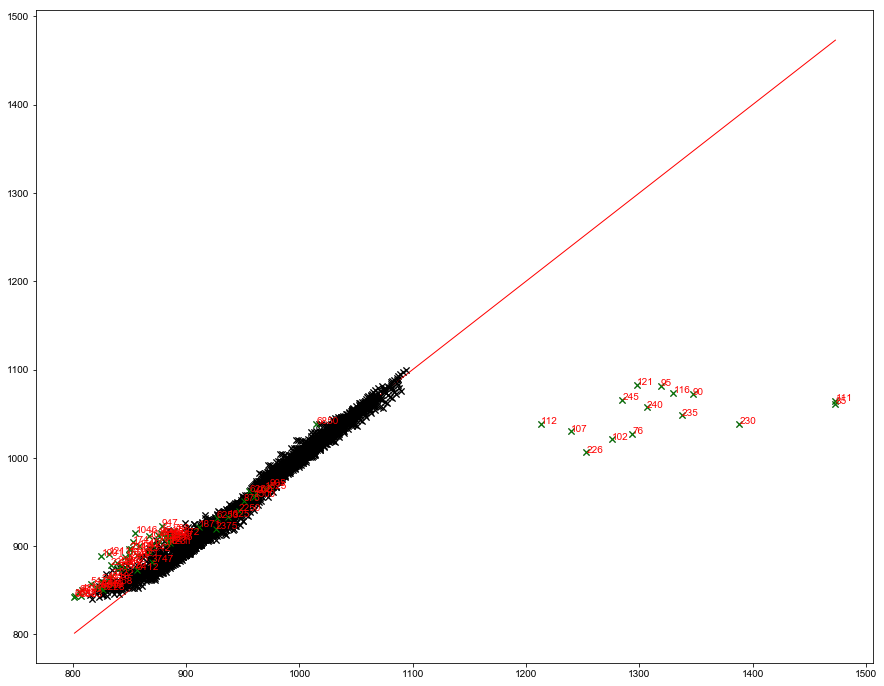

In [15]:
smry = fit_polynomial('A1', None, 2, reg=linear_model.RANSACRegressor())

fig, ax = plt.subplots(figsize=(15,12))
plot_fit(smry)

filtered_dataset = smry['filtered_dataset']
ransac = smry['reg']
dep_var = smry['dep_var']
ind_var_ = smry['ind_var_']

inlier_mask = ransac.inlier_mask_
outlier_mask = ~inlier_mask

# print(len(filtered_dataset.index), len(inlier_mask))
print(filtered_dataset[outlier_mask].index)

ax.plot(dep_var[inlier_mask], ransac.predict(ind_var_)[inlier_mask], 'kx')
ax.plot(dep_var[outlier_mask], ransac.predict(ind_var_)[outlier_mask], 'gx')

for idx, x, y in zip(filtered_dataset[outlier_mask].index, dep_var[outlier_mask], ransac.predict(ind_var_)[outlier_mask]):
    ax.text(x, y, str(idx), color='r')

In [13]:
filtered_dataset[outlier_mask]

,file,macro,C,Mn,Si,Cr,Ni,A1,A1prime,A3,eutectoid
76,../results/00076.DAT,../macros_thermocalc/macro_2.tcm,0.0000,0.000001,0.022500,0.000001,0.007501,1293.820,NaN,NaN,NaN
85,../results/00085.DAT,../macros_thermocalc/macro_2.tcm,0.0000,0.000001,0.022500,0.015000,0.000001,1473.000,NaN,NaN,NaN
90,../results/00090.DAT,../macros_thermocalc/macro_2.tcm,0.0000,0.000001,0.022500,0.022500,0.000001,1346.880,NaN,NaN,NaN
95,../results/00095.DAT,../macros_thermocalc/macro_2.tcm,0.0000,0.000001,0.022500,0.030000,0.000001,1318.960,NaN,NaN,NaN
102,../results/00102.DAT,../macros_thermocalc/macro_3.tcm,0.0000,0.000001,0.030000,0.000001,0.015000,1275.560,NaN,NaN,NaN
107,../results/00107.DAT,../macros_thermocalc/macro_3.tcm,0.0000,0.000001,0.030000,0.007501,0.015000,1239.950,NaN,NaN,NaN
111,../results/00111.DAT,../macros_thermocalc/macro_3.tcm,0.0000,0.000001,0.030000,0.015000,0.007501,1473.000,NaN,NaN,NaN
112,../results/00112.DAT,../macros_thermocalc/macro_3.tcm,0.0000,0.000001,0.030000,0.015000,0.015000,1213.010,NaN,NaN,NaN
116,../results/00116.DAT,../macros_thermocalc/macro_3.tcm,0.0000,0.000001,0.030000,0.022500,0.007501,1330.070,NaN,NaN,NaN
121,../results/00121.DAT,../macros_thermocalc/macro_3.tcm,0.0000,0.000001,0.030000,0.030000,0.007501,1297.980,NaN,NaN,NaN
